# 1. 数据预处理

OpenCV读取图片的维度是：**[高, 宽, 通道]**，其中通道的排布是BGR（蓝绿红）。

PyTorch要求图片数据集的维度是：**[样本, 通道, 高, 宽]**，其中通道的排布是RGB（红绿蓝）。

In [1]:
import torch

import numpy as np
import cv2
import matplotlib.pyplot as plt

import random

In [15]:
# 预定义常量
IMG_SIZE = 416    # 图片尺寸416x416
NUM_CLASSES = 20  # 20个类别
OBJ_CONF = 0.5
NMS_THRES = 0.4
CUDA = torch.cuda.is_available()

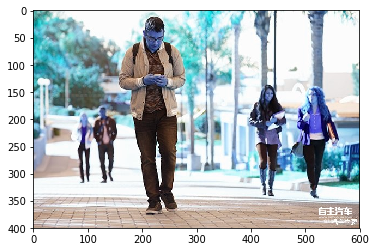

In [3]:
# 读取imgs文件夹中的图片文件1.jpg
img = cv2.imread("imgs/1.jpg")

# 这时图片颜色通道是BGR，本应是红色的变成了蓝色，所以人人都是阿凡达
plt.imshow(img)

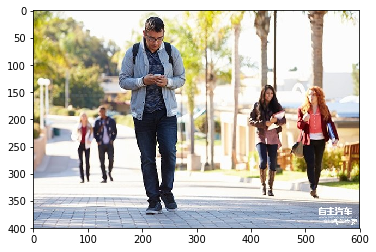

In [4]:
# [:,:,::-1]将图片的最后一个维度倒置，转换为RGB，现在肤色正常了
plt.imshow(img[:,:,::-1])

In [5]:
# 现在图片的格式为：高-宽-通道(H-W-C)
img.shape

(400, 600, 3)

### 1.1 图片填充

将原始图片填充至正方形再进行缩放，保证目标不变形。

In [6]:
# 获取图片高和宽，通道用_代替
h, w, _ = img.shape

# 高宽的差
dim_diff = np.abs(h-w)

# pad1, pad2分别是两侧（上下或左右）的填充距离
pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
pad = ((pad1, pad2), (0,0), (0,0)) if h < w else ((0,0), (pad1, pad2), (0,0))

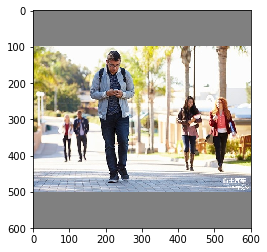

In [7]:
# 用灰色(128)填充图片
pad_img = np.pad(img, pad, "constant", constant_values=128)
ori_img = pad_img[:,:,::-1]
plt.imshow(ori_img)

In [8]:
# 将图片大小调整为416x416
img = cv2.resize(ori_img, (IMG_SIZE, IMG_SIZE ))

# PyTorch对图片数据集的维度要求为：通道-高-宽(C-H-W)
# 通过.transpose()调整维度
img_ = img[:,:,::-1].transpose((2,0,1))
img_.shape    # 3通道，416高，416宽

(3, 416, 416)

In [9]:
# 加入一个新轴，使之扩充为四维张量，首个维度对应样本数量，指一次输入多张图片到网络
# / 255.0是对图片的归一化，使像素值在[0, 1]范围内
img_ = img_[np.newaxis,:,:,:] / 255.0
img_.shape    # 1样本，3通道，416高，416宽

(1, 3, 416, 416)

In [10]:
# 转换为PyTorch Tensor格式
img_ = torch.from_numpy(img_).float()
img_.shape

torch.Size([1, 3, 416, 416])

### 1.2 封装函数

In [11]:
# 将图片预处理过程封装为一个函数，用于测试
def get_input_img(img_dir, img_size=IMG_SIZE):
    
    img = cv2.imread(img_dir)
    
    # 获取图片高和宽，通道用_代替
    h, w, _ = img.shape

    # 高宽的差
    dim_diff = np.abs(h-w)

    # pad1, pad2分别是两侧（上下或左右）的填充距离
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    pad = ((pad1, pad2), (0,0), (0,0)) if h < w else ((0,0), (pad1, pad2), (0,0))
    
    # 用灰色(128)填充图片
    pad_img = np.pad(img, pad, "constant", constant_values=128)
    ori_img = pad_img[:,:,::-1]
    
    # 调整尺寸为416x416，并将通道维度前置
    img_ = cv2.resize(ori_img, (IMG_SIZE, IMG_SIZE))
    img_ = img_.transpose((2,0,1))
    
    # 添加维度batch，并对图片归一化，转换为torch.tensor格式
    img_ = img_[np.newaxis,:,:,:] / 255.0
    img_ = torch.from_numpy(img_).float()
    
    return img_, ori_img

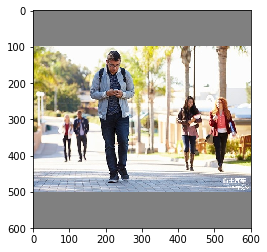

In [12]:
input_img, ori_img = get_input_img("imgs/1.jpg")
plt.imshow(ori_img)

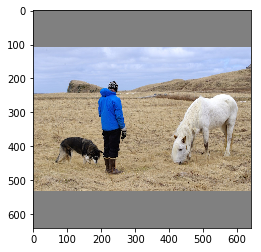

In [13]:
input_img, ori_img = get_input_img("imgs/person.jpg")
plt.imshow(ori_img)

![](imgs/ipy_pic/yolo.png)


# 2. 搭建DarkNet网络


In [17]:
from DarkNet import DarkNet

In [18]:
model = DarkNet(IMG_SIZE, NUM_CLASSES, transform=False)

In [19]:
# 共有5个类型的block(module): 
# convolutional, shortcut, yolo, route, upsample

module_types = []
for module in model.blocks:
    if module['type'] not in module_types:
        module_types.append(module['type'])
module_types

['convolutional', 'shortcut', 'yolo', 'route', 'upsample']

In [20]:
# route层
for i, module in enumerate(model.blocks):
    if module['type'] == 'route':
        print(i, module)

83 {'type': 'route', 'layers': '-4'}
86 {'type': 'route', 'layers': '-1, 61'}
95 {'type': 'route', 'layers': '-4'}
98 {'type': 'route', 'layers': '-1, 36'}


In [21]:
# yolo层
for i, module in enumerate(model.blocks):
    if module['type'] == 'yolo':
        print("{} {}".format(i-1, model.module_list[i-1]))
        print("{} {}".format(i, module))

81 Sequential(
  (conv_81): Conv2d(1024, 75, kernel_size=(1, 1), stride=(1, 1))
)
82 {'type': 'yolo', 'anchors': '116,90,  156,198,  373,326'}
93 Sequential(
  (conv_93): Conv2d(512, 75, kernel_size=(1, 1), stride=(1, 1))
)
94 {'type': 'yolo', 'anchors': '30,61,  62,45,  59,119'}
105 Sequential(
  (conv_105): Conv2d(256, 75, kernel_size=(1, 1), stride=(1, 1))
)
106 {'type': 'yolo', 'anchors': '10,13,  16,30,  33,23'}


每一个yolo层之前的卷积层，输出通道数都是75，每个grid输出3个BoundingBox，每个BBox是长度25的向量，即每个通道对应一个预测BBox。

In [22]:
# upsample层
for i, module in enumerate(model.blocks):
    if module['type'] == 'upsample':
        print("{} {}".format(i, module))

85 {'type': 'upsample'}
97 {'type': 'upsample'}


### 2.1 Route层的数据处理

In [23]:
model.blocks[83]['layers']

'-4'

In [24]:
[int(a) for a in model.blocks[83]['layers'].split(",")]

[-4]

In [25]:
[int(a) for a in model.blocks[86]['layers'].split(",")]

[-1, 61]

### 2.2 YOLO层的数据处理

In [26]:
model.blocks[82]['anchors']

'116,90,  156,198,  373,326'

In [27]:
anchors = [int(a) for a in model.blocks[82]['anchors'].split(",")]
anchors

[116, 90, 156, 198, 373, 326]

In [28]:
anchors = [(anchors[j], anchors[j + 1]) for j in range(0, len(anchors), 2)]
anchors

[(116, 90), (156, 198), (373, 326)]

### 2.3 输出测试

读取一张实例图片并传入DarkNet网络，查看输出张量结构

In [31]:
input_img, _ = get_input_img("imgs/person.jpg")

In [32]:
detections, output106, output94, output82 = model(input_img)

In [33]:
# 第82层的输出最小（stride最大）
output82.shape

torch.Size([1, 75, 13, 13])

In [34]:
output94.shape

torch.Size([1, 75, 26, 26])

In [35]:
# 最后一层的输出最大（stride最小）
output106.shape

torch.Size([1, 75, 52, 52])

### 3. 辅助工具函数

### 3.1 计算两个矩形的IoU

![](imgs/ipy_pic/iou.png)

In [36]:
def bbox_iou(box1, box2):
    
    # box数据格式：x1 y1（左上角） x2 y2（右下角）
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    # 重合区域左上角坐标：两个box的x1,y1中较大者
    inter_x1 = torch.max(b1_x1, b2_x1)
    inter_y1 = torch.max(b1_y1, b2_y1)
    
    # 重合区域右下角坐标：两个box的x2,y2中较小者
    inter_x2 = torch.min(b1_x2, b2_x2)
    inter_y2 = torch.min(b1_y2, b2_y2)
    
    # torch.clamp：如果参数小于min，则输出min
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * \
                 torch.clamp(inter_y2 - inter_y1, min=0)
        
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
        
    iou = inter_area / (b1_area + b2_area - inter_area)
    return iou

IoU计算函数测试

![](imgs/ipy_pic/iou_test.png)

In [37]:
bbox_iou(torch.tensor([[0.,0.,4.,4.],
                       [0.,0.,4.,4.],
                       [0.,0.,4.,4.]]),
         torch.tensor([[1.,1.,5.,5.],
                       [2.,2.,6.,6.],
                       [1.,1.,3.,3.]]))

tensor([0.3913, 0.1429, 0.2500])

In [38]:
# 如果有矩形原本面积为0，则输出nan，不影响后续计算
bbox_iou(torch.tensor([[0.,0.,0.,0.]]),
         torch.tensor([[0.,0.,0.,0.]]))

tensor([nan])

### 3.2 目标检测结果变换

YOLO v3将特征映射划分为若干grid，每个grid输出3个预测BoundingBox。

为了便于计算损失函数，需对来自网络的特征映射做变换，以第82层的特征映射为例。

![](imgs/ipy_pic/yolo-5.png)

In [39]:
input_dim = int(IMG_SIZE)
batch_size = output82.shape[0]
stride = input_dim // output82.shape[2]
num_grids = output82.shape[2]

bbox_attrs = 5 + NUM_CLASSES
num_anchors = len(anchors)

In [40]:
print("Num of Anchors = {}\nNum of Grids  = {}\nBBox attrs = {}\nStride = {}".format(num_anchors, num_grids, bbox_attrs, stride))

Num of Anchors = 3
Num of Grids  = 13
BBox attrs = 25
Stride = 32


![](imgs/ipy_pic/predict_transform_1.png)

![](imgs/ipy_pic/predict_transform_2.png)

![](imgs/ipy_pic/predict_transform_3.png)

In [41]:
# bbox_attrs * num_anchors对应通道数75
# 将高和宽合并为一个维度
pred = output82.view(batch_size, bbox_attrs * num_anchors, num_grids * num_grids)
pred.shape

torch.Size([1, 75, 169])

In [42]:
# 调整张量排布，每个样本在第82层有13x13=169个预测BBox，每个BBox是长度75的向量
# .transpose()之后需要.contiguous()，使数据在内存中连续
pred = pred.transpose(1,2).contiguous()
pred.shape

torch.Size([1, 169, 75])

In [43]:
pred = pred.view(batch_size, num_grids * num_grids * num_anchors, bbox_attrs)
pred.shape

torch.Size([1, 507, 25])

In [44]:
# pred[:,:,0]: center_x of BBox
# pred[:,:,1]: center_y of BBox
# pred[:,:,4]: object confidence

# 将x,y,confidence经过sigmoid函数限制在[0,1]
pred[:,:,0] = torch.sigmoid(pred[:,:,0])
pred[:,:,1] = torch.sigmoid(pred[:,:,1])
pred[:,:,4] = torch.sigmoid(pred[:,:,4])

In [45]:
pred

tensor([[[ 0.4879,  0.4807,  0.1462,  ..., -0.3964,  0.1079, -0.3067],
         [ 0.5823,  0.5433,  0.2045,  ..., -0.0451, -0.0020,  0.0609],
         [ 0.5412,  0.5059,  0.1123,  ..., -0.0404,  0.0805,  0.1025],
         ...,
         [ 0.4473,  0.5041, -0.0021,  ..., -0.3057, -0.0731, -0.2203],
         [ 0.5480,  0.4768,  0.0848,  ...,  0.1485, -0.0589, -0.0323],
         [ 0.5314,  0.4632, -0.3545,  ...,  0.2541,  0.3368, -0.1267]]],
       grad_fn=<AsStridedBackward>)

##### 3.2.1 Anchor处理

In [46]:
grid = np.arange(num_grids)
a, b = np.meshgrid(grid, grid)

x_offset = torch.FloatTensor(a).view(-1, 1)
y_offset = torch.FloatTensor(b).view(-1, 1)

In [47]:
# .unsqueeze(0)：扩充第0维
x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1, num_anchors).view(-1, 2).unsqueeze(0)

![](imgs/ipy_pic/anchors_transform.png)

![](imgs/ipy_pic/e.png)

In [48]:
# 预测 + 偏移 = 绝对位置
# b_x = sigma(t_x) + c_x
# b_y = sigma(t_y) + c_y
pred[:,:,:2] += x_y_offset

In [49]:
pred[:,:,:2]

tensor([[[ 0.4879,  0.4807],
         [ 0.5823,  0.5433],
         [ 0.5412,  0.5059],
         ...,
         [12.4473, 12.5041],
         [12.5480, 12.4768],
         [12.5314, 12.4632]]], grad_fn=<SliceBackward>)

In [50]:
# 此时的Anchors尺寸是对应416x416，需要转换到当前特征映射大小(13x13)
anchors

[(116, 90), (156, 198), (373, 326)]

In [51]:
anchors = [(a[0]/stride, a[1]/stride) for a in anchors]
anchors

[(3.625, 2.8125), (4.875, 6.1875), (11.65625, 10.1875)]

In [52]:
anchors = torch.FloatTensor(anchors)
anchors = anchors.repeat(num_grids * num_grids, 1).unsqueeze(0)

# b_w = p_w * e^(t_w)
# b_h = p_h * e^(t_h)
pred[:,:,2:4] = torch.exp(pred[:,:,2:4]) * anchors
pred[:,:,5:] = torch.sigmoid(pred[:,:,5:])
                                  
pred[:,:,:4] *= stride

In [53]:
pred

tensor([[[1.5612e+01, 1.5384e+01, 1.3426e+02,  ..., 4.0218e-01,
          5.2695e-01, 4.2392e-01],
         [1.8633e+01, 1.7385e+01, 1.9140e+02,  ..., 4.8873e-01,
          4.9950e-01, 5.1521e-01],
         [1.7318e+01, 1.6189e+01, 4.1731e+02,  ..., 4.8990e-01,
          5.2011e-01, 5.2560e-01],
         ...,
         [3.9831e+02, 4.0013e+02, 1.1575e+02,  ..., 4.2417e-01,
          4.8174e-01, 4.4514e-01],
         [4.0154e+02, 3.9926e+02, 1.6980e+02,  ..., 5.3706e-01,
          4.8528e-01, 4.9192e-01],
         [4.0100e+02, 3.9882e+02, 2.6167e+02,  ..., 5.6320e-01,
          5.8341e-01, 4.6838e-01]]], grad_fn=<AsStridedBackward>)

##### 3.2.2 封装函数

In [54]:
def predict_transform(pred, anchors, input_dim, num_classes):
    
    # 是否支持CUDA
    CUDA = torch.cuda.is_available()
    
    # pred: 来自卷积神经网络的输出，第0个维度为batch size
    batch_size = pred.shape[0]
    stride = input_dim // pred.shape[2]
    num_grids = pred.shape[2]

    # BoundingBox属性向量的长度
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
        
    # [1, 75, num_grids, num_grids] -> [1, num_grids * num_grids * num_anchors, 25]
    # pred: 每行对应一个Bounding Box属性向量
    pred = pred.view(batch_size, bbox_attrs * num_anchors, num_grids * num_grids)
    pred = pred.transpose(1,2).contiguous()
    pred = pred.view(batch_size, num_grids * num_grids * num_anchors, bbox_attrs)
    
    pred[:,:,0] = torch.sigmoid(pred[:,:,0])  # center_x
    pred[:,:,1] = torch.sigmoid(pred[:,:,1])  # center_y
    pred[:,:,4] = torch.sigmoid(pred[:,:,4])  # object confidence
        
    # 计算BBox相对Grid的偏移
    grid = np.arange(num_grids)
    a, b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1, 1)
    y_offset = torch.FloatTensor(b).view(-1, 1)

    # 如果支持CUDA，则转换为GPU并行变量
    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()
        pred = pred.cuda()
        
    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1, num_anchors).view(-1, 2).unsqueeze(0)
    pred[:,:,:2] += x_y_offset
    
    # 根据stride变换Anchors尺寸
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]
    
    anchors = torch.FloatTensor(anchors) 
    
    if CUDA:
        anchors = anchors.cuda()
    
    anchors = anchors.repeat(num_grids * num_grids, 1).unsqueeze(0)
    
    # 根据Anchors尺寸变换预测输出
    pred[:,:,2:4] = torch.exp(pred[:,:,2:4]) * anchors
    pred[:,:,5:] = torch.sigmoid(pred[:,:,5:])

    # x, y, w, h：还原到416x416尺度
    pred[:,:,:4] *= stride
    
    return pred

In [55]:
# 重新生成anchors，因为在之前的计算中anchors已经改变
anchors = [int(a) for a in model.blocks[82]['anchors'].split(",")]
anchors = [(anchors[j], anchors[j + 1]) for j in range(0, len(anchors), 2)]

In [56]:
prediction = predict_transform(output82, anchors, IMG_SIZE, NUM_CLASSES)

In [57]:
prediction

tensor([[[1.5612e+01, 1.5384e+01, 1.3426e+02,  ..., 4.0218e-01,
          5.2695e-01, 4.2392e-01],
         [1.8633e+01, 1.7385e+01, 1.9140e+02,  ..., 4.8873e-01,
          4.9950e-01, 5.1521e-01],
         [1.7318e+01, 1.6189e+01, 4.1731e+02,  ..., 4.8990e-01,
          5.2011e-01, 5.2560e-01],
         ...,
         [3.9831e+02, 4.0013e+02, 1.1575e+02,  ..., 4.2417e-01,
          4.8174e-01, 4.4514e-01],
         [4.0154e+02, 3.9926e+02, 1.6980e+02,  ..., 5.3706e-01,
          4.8528e-01, 4.9192e-01],
         [4.0100e+02, 3.9882e+02, 2.6167e+02,  ..., 5.6320e-01,
          5.8341e-01, 4.6838e-01]]], device='cuda:0', grad_fn=<CopySlices>)

In [58]:
prediction.shape

torch.Size([1, 507, 25])

### 3.3 输出测试

In [59]:
# 创建DarkNet对象实例
darknet = DarkNet(IMG_SIZE, NUM_CLASSES)

# 载入预训练参数
darknet.load_state_dict(torch.load("weights/Dartnet_VOC_Weights"))

if CUDA:
    darknet.cuda()

# 切换为预测模式
darknet.eval()

DarkNet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [60]:
if CUDA:
    input_img = input_img.cuda()
    
prediction, _, _, _ = darknet(input_img)

In [61]:
# 对于每张输入图片，DarkNet输出(52 * 52 + 26 * 26 + 13 * 13) * 3 = 10647个预测，每个预测长度为25
prediction.shape

torch.Size([1, 10647, 25])

# 4. 非极大抑制(Non-maximum Supression)

Darknet的原始输出为[10647, 25]，其中[5:]的20位对应PascalVOC数据集的20个类别。

首先根据object confidence筛选有把握检测到目标的BoundingBox。

然后留下最高概率的类别得分，以及对应的类别。

最终的YOLO输出为[X, 8]：

![](imgs/ipy_pic/nms.png)

In [62]:
# prediction[:,:,4]对应object confidence
prediction[:,:,4]

tensor([[2.8780e-28, 1.5203e-17, 2.0495e-15,  ..., 1.6136e-13, 2.0956e-11,
         2.7280e-11]], device='cuda:0', grad_fn=<SelectBackward>)

In [63]:
# 筛选object confidence大于0.5
(prediction[:,:,4] > 0.5).float().shape

torch.Size([1, 10647])

In [64]:
# 调整张量维度，以便与原prediction相乘
(prediction[:,:,4] > 0.5).float().unsqueeze(2).shape

torch.Size([1, 10647, 1])

In [65]:
conf_mask = (prediction[:,:,4] > 0.5).float().unsqueeze(2)
# 大于0.5的保留，小于0.5的变为0
prediction = prediction * conf_mask

In [66]:
# 创建与prediction形状相同的空矩阵
box_corner = prediction.new(prediction.shape)
box_corner.shape

torch.Size([1, 10647, 25])

In [67]:
# BBox左上角x坐标 = BBox中心x坐标 - BBox宽度的一半
box_corner[:,:,0] = prediction[:,:,0] - prediction[:,:,2] / 2

# BBox左上角y坐标 = BBox中心y坐标 - BBox高度的一半
box_corner[:,:,1] = prediction[:,:,1] - prediction[:,:,3] / 2

# BBox右下角x坐标 = BBox中心x坐标 + BBox宽度的一半
box_corner[:,:,2] = prediction[:,:,0] + prediction[:,:,2] / 2

# BBox右下角y坐标 = BBox中心y坐标 + BBox高度的一半
box_corner[:,:,3] = prediction[:,:,1] + prediction[:,:,3] / 2

In [68]:
prediction[:,:,:4] = box_corner[:,:,:4]

### 4.1 torch.max()

返回指定维度的最大值，以及最大值的位置

In [70]:
a = torch.randn((2,3))
a

tensor([[ 1.0240, -0.7506,  0.3651],
        [ 0.5601, -0.0209, -1.2622]])

In [71]:
torch.max(a, 1)

torch.return_types.max(
values=tensor([1.0240, 0.5601]),
indices=tensor([0, 0]))

### 4.2 torch.nonzero()

返回非零值的位置

In [72]:
torch.nonzero(a)

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2]])

### 4.3 Non-Maximum Suppression

In [73]:
# batch中的第0个输出
i = 0
    
bbox_pred = prediction[i]

# torch.max(<Tensor>, 1): 返回第1维上的最大值，即按列压缩，取每一行的最大值
# max_conf：返回每行（grid）的最大值
# max_conf_score：返回每行最大值出现的位置，也就是20个类别中概率最大的
max_conf, max_conf_id = torch.max(bbox_pred[:,5:], 1)

# 将因为.max()压缩的维度填充回去，保持与pred一致
max_conf = max_conf.float().unsqueeze(1)
max_conf_id = max_conf_id.float().unsqueeze(1)

# 用max_conf和max_conf_id替代原来的20个数值
bbox_pred = torch.cat((bbox_pred[:,:5], max_conf, max_conf_id), 1)
# 查找object confidence非零（即原始输出大于0.5）的grid编号
non_zero_id = torch.nonzero(bbox_pred[:,4]).squeeze()

# 筛选object confidence非零的Bouding Box
bbox_det = bbox_pred[non_zero_id]

# 如果没有非零confidence（图里没检测到东西）
if bbox_det.shape[0] == 0:
    pass

# bbox_det[:,-1]: -1列为最大概率对应类别（0-19）
det_classes = torch.unique(bbox_det[:,-1])

In [74]:
# 当前输入图片中检测到的目标类别
det_classes

tensor([11., 12., 14.], device='cuda:0', grad_fn=<NotImplemented>)

In [75]:
# 以类别12为例

cls = 12

# cls_mask: 筛选最大概率的类别是当前cls的BBox
cls_mask = bbox_det * (bbox_det[:,-1] == cls).float().unsqueeze(1)
cls_mask_id = torch.nonzero(cls_mask[:,-2]).squeeze()
# image_det -> image_det_class: 针对当前类别的检测
bbox_det_class = bbox_det[cls_mask_id]

In [76]:
cls_mask_id

tensor([0, 2, 3, 5], device='cuda:0')

In [77]:
bbox_det_class = bbox_det[cls_mask_id].view(-1, 7)
bbox_det_class

tensor([[253.8424, 170.3822, 398.4124, 286.2887,   0.5577,   1.0000,  12.0000],
        [263.2454, 157.3722, 390.5781, 288.3984,   0.8203,   1.0000,  12.0000],
        [261.6743, 165.0688, 385.7211, 289.0938,   0.9786,   1.0000,  12.0000],
        [258.0816, 158.6988, 390.8615, 294.9577,   0.6404,   1.0000,  12.0000]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [79]:
# 在当前类别cls中，按照confidence高到低排序
conf_sort_id = torch.sort(bbox_det_class[:,4], descending=True)[1]

# 对当前类别cls的检测结果重新排序
bbox_det_class = bbox_det_class[conf_sort_id]
bbox_det_class

tensor([[261.6743, 165.0688, 385.7211, 289.0938,   0.9786,   1.0000,  12.0000],
        [263.2454, 157.3722, 390.5781, 288.3984,   0.8203,   1.0000,  12.0000],
        [258.0816, 158.6988, 390.8615, 294.9577,   0.6404,   1.0000,  12.0000],
        [253.8424, 170.3822, 398.4124, 286.2887,   0.5577,   1.0000,  12.0000]],
       device='cuda:0', grad_fn=<IndexBackward>)

In [81]:
# 当前输出有4个BBox指向类别12
num_bboxes = bbox_det_class.shape[0]
num_bboxes

4

In [82]:
j = 0

# 类别12的BBox[0]与另外3个BBox的IoU过高，只保留BBox[0]
ious = bbox_iou(bbox_det_class[j].unsqueeze(0), bbox_det_class[j+1:])
ious

tensor([0.8904, 0.8503, 0.8094], device='cuda:0', grad_fn=<DivBackward0>)

In [83]:
iou_mask = (ious < 0.4).float().unsqueeze(1)
bbox_det_class[j+1:] *= iou_mask

In [84]:
# 与BBox[0]的IoU过高的BBox被置为0
iou_mask

tensor([[0.],
        [0.],
        [0.]], device='cuda:0')

In [85]:
bbox_det_class

tensor([[261.6743, 165.0688, 385.7211, 289.0938,   0.9786,   1.0000,  12.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],
       device='cuda:0', grad_fn=<CopySlices>)

In [86]:
# 经过NMS筛选，保留的BBox编号
non_zero_id = torch.nonzero(bbox_det_class[:,4]).squeeze()

# 此时类别12的BBox只留下一个
bbox_det_class = bbox_det_class[non_zero_id].view(-1,7)
bbox_det_class

tensor([[261.6743, 165.0688, 385.7211, 289.0938,   0.9786,   1.0000,  12.0000]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [87]:
sample_id = bbox_det_class.new(bbox_det_class.shape[0], 1).fill_(i)
detections = torch.cat((sample_id, bbox_det_class), 1)

In [88]:
detections

tensor([[  0.0000, 261.6743, 165.0688, 385.7211, 289.0938,   0.9786,   1.0000,
          12.0000]], device='cuda:0', grad_fn=<CatBackward>)

### 4.3 封装函数

In [89]:
def bbox_nms(pred, obj_conf=0.5, nms_thres=0.4):

    # pred[:,:,4]：object confidence
    # .float()：布尔变量 -> 浮点数
    # .unsqueeze(2)：增加维度，与pred形状一致
    # [1, 10647] -> [1, 10647, 1]
    conf_mask = (pred[:,:,4] > obj_conf).float().unsqueeze(2)
    
    # 与mask相乘，大于conf的保留，小于conf的变为0
    pred = pred * conf_mask

    box_corner = pred.new(pred.shape)
    # BBox左上角x坐标 = BBox中心x坐标 - BBox宽度的一半
    box_corner[:,:,0] = pred[:,:,0] - pred[:,:,2] / 2
    # BBox左上角y坐标 = BBox中心y坐标 - BBox高度的一半
    box_corner[:,:,1] = pred[:,:,1] - pred[:,:,3] / 2
    # BBox右下角x坐标 = BBox中心x坐标 + BBox宽度的一半
    box_corner[:,:,2] = pred[:,:,0] + pred[:,:,2] / 2
    # BBox右下角y坐标 = BBox中心y坐标 + BBox高度的一半
    box_corner[:,:,3] = pred[:,:,1] + pred[:,:,3] / 2
    pred[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = pred.shape[0]
    write = 0

    # 对Batch中的样本循环
    for i in range(batch_size):
        
        bbox_pred = pred[i]
        
        # torch.max(<Tensor>, 1): 返回第1维上的最大值，即按列压缩，取每一行的最大值
        # max_conf：返回每行（grid）的最大值
        # max_conf_score：返回每行最大值出现的位置，也就是20个类别中概率最大的
        max_conf, max_conf_id = torch.max(bbox_pred[:,5:], 1)
        
        # 将因为.max()压缩的维度填充回去，保持与pred一致
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_id = max_conf_id.float().unsqueeze(1)
        
        bbox_pred = torch.cat((bbox_pred[:,:5], max_conf, max_conf_id), 1)
        # 查找object confidence非零（即原始输出大于0.5）的grid编号
        non_zero_id = torch.nonzero(bbox_pred[:,4]).squeeze()
        
        # 筛选object confidence非零的Bouding Box
        bbox_det = bbox_pred[non_zero_id]
        
        # 如果没有非零confidence（图里没检测到东西）
        if bbox_det.shape[0] == 0:
            output = torch.tensor([])
            continue
        
        # image_det[:,-1]: -1列为最大概率对应类别（0-19）
        det_classes = torch.unique(bbox_det[:,-1])
        
        # 对数据集中的类别循环
        for cls in det_classes:
            
            # cls_mask: 筛选最大概率的类别是当前cls的BBox
            cls_mask = bbox_det * (bbox_det[:,-1] == cls).float().unsqueeze(1)
            cls_mask_id = torch.nonzero(cls_mask[:,-2]).squeeze()
            # bbox_det -> bbox_det_class: 针对当前类别的检测
            bbox_det_class = bbox_det[cls_mask_id].view(-1,7)
                                    
            # 在当前类别cls中，按照confidence高到低排序
            conf_sort_id = torch.sort(bbox_det_class[:,4], descending=True)[1]
            # 对当前类别cls的检测结果重新排序
            bbox_det_class = bbox_det_class[conf_sort_id]
            
            num_bboxes = bbox_det_class.shape[0]
            
            # 对BoundingBoxes循环
            for j in range(num_bboxes-1):
                
                # 计算第j个BBox，与之后所有BBox的IoU
                ious = bbox_iou(bbox_det_class[j].unsqueeze(0), bbox_det_class[j+1:])
                
                # 如果存在第j个之后的BBox，与当前BBox的IoU过高，则过滤为0
                # 因为bbox_det_class已经按照confidence高到低排序，所以扔掉后面的
                iou_mask = (ious < nms_thres).float().unsqueeze(1)
                bbox_det_class[j+1:] *= iou_mask
                
            non_zero_id = torch.nonzero(bbox_det_class[:,4]).squeeze()
            bbox_det_class = bbox_det_class[non_zero_id].view(-1,7)  
            
            # 行数：经过NMS的BBox数量，列数：1，以当前sample id填充
            sample_id = bbox_det_class.new(bbox_det_class.shape[0], 1).fill_(i)
            detections = torch.cat((sample_id, bbox_det_class), 1)
            
            if not write:
                output = detections
                write = 1
                
            else:
                output = torch.cat((output, detections))

    return output

In [90]:
# 在之前的测试过程中prediction已经改变，因此重新生成预测结果
prediction, _, _, _ = darknet(input_img)

In [91]:
output = bbox_nms(prediction, OBJ_CONF, NMS_THRES)

In [92]:
# 经过NMS筛选，留下3个BoundingBox，即最终检测结果
output

tensor([[  0.0000,  45.7615, 239.6671, 137.4619, 310.7432,   0.9962,   0.9998,
          11.0000],
        [  0.0000, 261.6743, 165.0688, 385.7211, 289.0938,   0.9786,   1.0000,
          12.0000],
        [  0.0000, 127.9755, 125.9541, 182.7271, 324.5595,   0.5182,   1.0000,
          14.0000]], device='cuda:0', grad_fn=<CatBackward>)

# 5. 数据可视化

Pascal VOC数据集共有20个类别的图像：

In [93]:
obj_classes = ['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [95]:
import pickle as pkl

# 给每个类别分配颜色
obj_colors = pkl.load(open("data/pallete", "rb"))

# 随机分配20种颜色
obj_colors = random.sample(obj_colors, NUM_CLASSES)

### 5.1 绘制Bounding Box

YOLO网络首先将输入图片变为416x416大小，在此基础上进行目标检测，检测框BoundingBox也是在416x416的空间内，需要将BBox的坐标变回原始图片空间。

In [96]:
def bbox_transform(output, ori_img, img_size=IMG_SIZE):
    
    # torch.clamp:如果坐标位置超出图片范围，则改为图片边缘
    # 按比例缩放BBox
    output_ = output.clone()
    output_[:, 1:5] = torch.clamp(output[:, 1:5], 0, float(img_size))
    output_  *=  (ori_img.shape[0] / img_size)
    
    # 获取BBox的左上-右下角坐标
    # .int(): 绘制图片需要整数型坐标点
    pt1 = output_[:,1:3].data.int().cpu().numpy()
    pt2 = output_[:,3:5].data.int().cpu().numpy()
    
    pt1 = [tuple(p) for p in pt1]
    pt2 = [tuple(p) for p in pt2]
    
    return pt1, pt2

In [97]:
pt1, pt2 = bbox_transform(output, ori_img)

In [98]:
# 经过尺度变换后的BBox坐标
print("pt1: {}\npt2: {}".format(pt1, pt2))

pt1: [(70, 368), (402, 253), (196, 193)]
pt2: [(211, 478), (593, 444), (281, 499)]


In [99]:
len(output)

3

In [102]:
bbox_img = ori_img.copy()

for i in range(len(output)):
    
    # 当前BBox的分类编号与文字标签
    cls = int(output[i, -1])
    label = "{}".format(obj_classes[cls])
    color = obj_colors[cls]
    
    # 绘制目标检测框
    cv2.rectangle(bbox_img, pt1[i], pt2[i], color, 2)
    
    # 标签文字尺寸
    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)[0]
    
    # 标签框右下角坐标
    text_pt2 = (pt1[i][0] + text_size[0], pt1[i][1] + text_size[1] + 4)
    
    # 绘制分类标签框
    cv2.rectangle(bbox_img, pt1[i], text_pt2, color, -1)
    
    # 写入标签文字
    cv2.putText(bbox_img, label, (pt1[i][0], pt1[i][1] + text_size[1] + 4), cv2.FONT_HERSHEY_SIMPLEX, 1, [255, 255, 255], 1)

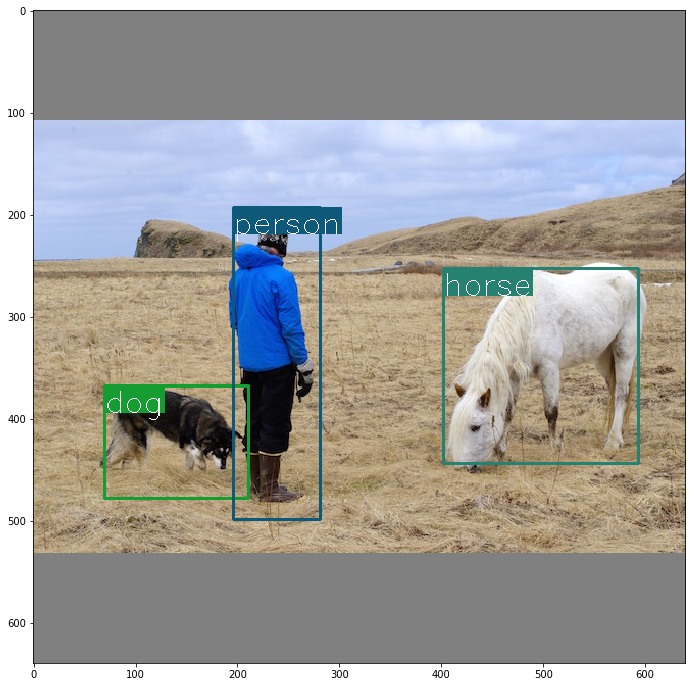

In [103]:
plt.figure(figsize=(16, 12))
plt.imshow(bbox_img)

### 5.2 封装测试函数

In [110]:
def visualize_yolo(model, img_dir, img_size, obj_classes, obj_conf=0.5, nms_thres=0.4, CUDA=True):
    
    input_img, ori_img = get_input_img(img_dir, img_size)
    
    if CUDA:
        input_img = input_img.cuda()
    
    prediction, _, _, _ = darknet(input_img)
    
    output = bbox_nms(prediction, obj_conf, nms_thres)
    bbox_img = ori_img.copy()
    
    # 如果图中未检测到目标，则直接返回原图
    if len(output) == 0:
        plt.imshow(bbox_img)
        return bbox_img
    
    pt1, pt2 = bbox_transform(output, ori_img, img_size)
    
    obj_colors = pkl.load(open("data/pallete", "rb"))
    obj_colors = random.sample(obj_colors, len(obj_classes))

    for i in range(len(output)):

        cls = int(output[i, -1])
        label = "{}".format(obj_classes[cls])
        color = obj_colors[cls]

        cv2.rectangle(bbox_img, pt1[i], pt2[i], color, 2)

        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)[0]
        text_pt2 = (pt1[i][0] + text_size[0], pt1[i][1] + text_size[1] + 4)

        cv2.rectangle(bbox_img, pt1[i], text_pt2, color, -1)

        cv2.putText(bbox_img, label, (pt1[i][0], pt1[i][1] + text_size[1] + 4), cv2.FONT_HERSHEY_SIMPLEX, 1, [255, 255, 255], 1)
    
    plt.imshow(bbox_img)
    return bbox_img

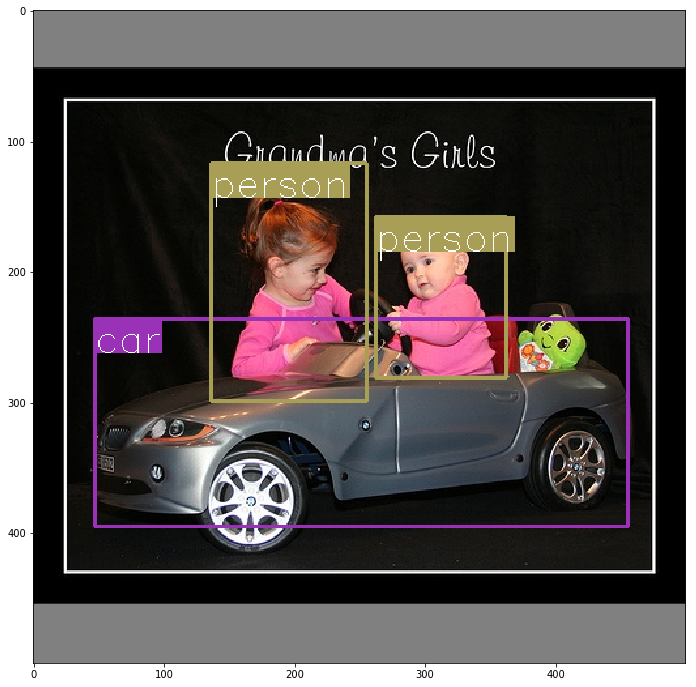

In [111]:
vis_img = visualize_yolo(darknet, "imgs/baby.jpg",  "weights/Dartnet_VOC_Weights", obj_classes)